<a href="https://colab.research.google.com/github/hyxxnii/NLP-Practice/blob/master/Word%20Embedding/02.%20%EB%84%A4%EA%B1%B0%ED%8B%B0%EB%B8%8C%20%EC%83%98%ED%94%8C%EB%A7%81%EC%9D%84%20%EC%9D%B4%EC%9A%A9%ED%95%9C%20Word2Vec%20%EA%B5%AC%ED%98%84(Skip%20Gram%20with%20Negative%20Sampling%2C%20SGNS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

네거티브 샘플링(Negative Sampling)을 사용하는 Word2Vec을 직접 케라스(Keras)를 통해 구현해보자

Reference: https://wikidocs.net/69141

sklearn에서 제공하는 20뉴스그룹 dataset

## 20뉴스그룹 dataset 전처리

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

이번 실습에서는 하나의 샘플에 최소 단어 2개가 있어야 한다. (중심단어, 주변단어의 관계 성립을 위해)

따라서 전처리 과정을 통해 이를 만족하지 않는 샘플을 제거할 예정이다.

In [2]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :', len(documents))

총 샘플 수 : 11314


In [4]:
news_df = pd.DataFrame({'document':documents})

# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3 이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

news_df.head()

document                                          clean_doc
0  Well i'm not sure about the story nad it did s...  well sure about story seem biased what disagre...
1  \n\n\n\n\n\n\nYeah, do you expect people to re...  yeah expect people read actually accept hard a...
2  Although I realize that principle is not one o...  although realize that principle your strongest...
3  Notwithstanding all the legitimate fuss about ...  notwithstanding legitimate fuss about this pro...
4  Well, I will have to change the scoring on my ...  well will have change scoring playoff pool unf...

In [5]:
news_df.isnull().values.any()

False

In [6]:
# 빈 값(empty)을 Null 값으로 변환 후 다시 Null 값 확인
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [7]:
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


In [9]:
# NLTK에서 정의한 불용어 리스트를 사용하여 불용어 제거
nltk.download('stopwords')
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [17]:
# 단어 집합 생성, 정수인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [18]:
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [32]:
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


## 네거티브 샘플링을 통한 데이터셋 구성하기

- 네거티브 샘플링을 위해서 케라스에서 제공하는 전처리 도구인 skipgrams를 사용
- 시간이 꽤 걸리는 작업이므로 우선 확인을 위해 상위 10개 뉴스그룹 샘플에 대해서만 수행해보자

In [20]:
from tensorflow.keras.preprocessing.sequence import skipgrams

# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [21]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(israeli (442), squared (23414)) -> 0
(israeli (442), koutd (12927)) -> 0
(away (178), received (634)) -> 1
(received (634), neurobehav (45480)) -> 0
(ignore (1979), qshzq (60033)) -> 0


윈도우 크기 내에서 중심 단어, 주변 단어의 관계를 가지는 경우에는 1의 레이블을 갖도록 하고, 그렇지 않은 경우는 0의 레이블을 가지도록 하여 데이터셋을 구성한다.

In [28]:
print('전체 샘플 수 :',len(skip_grams))

# 10개의 뉴스그룹 샘플 각각은 수많은 중심 단어, 주변 단어의 쌍으로 된 샘플들을 갖고 있다

전체 샘플 수 : 10


In [33]:
# 첫번째 뉴스그룹 샘플(10개)에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


이 작업을 모든 뉴스그룹 샘플에 대해서 수행해보자.

In [34]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

## Skip-Gram with Negative Sampling(SGNS) 구현하기

Skip-gram을 직접 구현해보자

In [35]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG


In [36]:
# 임베딩 벡터의 차원은 100으로 (하이퍼파라미터)
embed_size = 100

In [37]:
# 모델 설계 -> 두 개의 임베딩 테이블을 생성

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embed_size)(c_inputs)

각 단어는 임베딩 테이블을 거쳐서 내적을 수행하고, 내적의 결과는 1 또는 0을 예측하기 위해서 시그모이드 함수를 활성화 함수로 거쳐 최종 예측값을 얻는다.

In [38]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       6427700     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       6427700     input_2[0][0]                    
____________________________________________________________________________________________

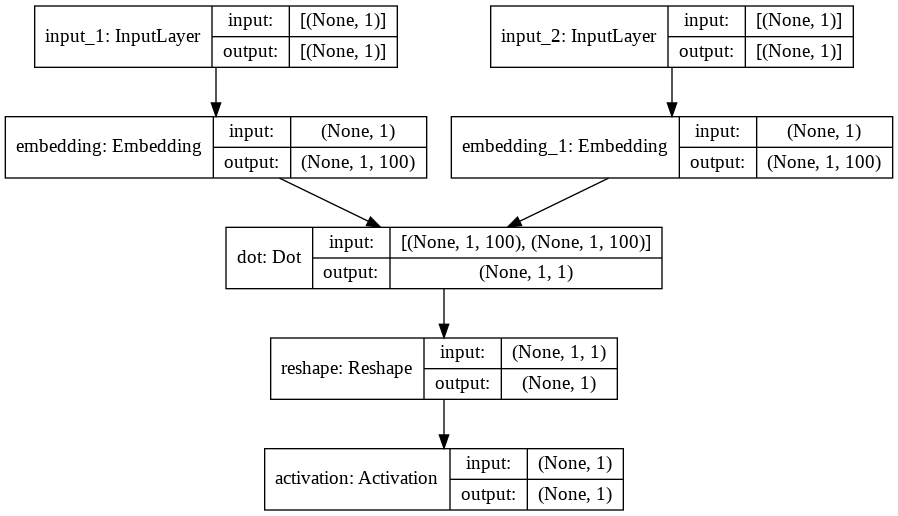

In [40]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [41]:
# 모델 학습: 5 epochs
# 학습 시간 생각보다 오래 걸린당.. 1 Epoch 도는데 약 30분 걸림

for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 4625.446107879281
Epoch : 2 Loss : 3656.663914212957
Epoch : 3 Loss : 3495.4674064610153
Epoch : 4 Loss : 3301.890072095208
Epoch : 5 Loss : 3079.0945452852175


## 학습된 모델 결과 확인

In [42]:
import gensim

# 학습된 임베딩 벡터 저장
f = open('SGNS_vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [44]:
# gensim의 .models.KeyedVectors.load_word2vec_format로 로드

w2v = gensim.models.KeyedVectors.load_word2vec_format('./SGNS_vectors.txt', binary=False)
w2v.most_similar(positive=['soldiers'])

[('towns', 0.8388919234275818),
 ('wounded', 0.8228965997695923),
 ('cypriot', 0.8213711380958557),
 ('systematic', 0.8194918632507324),
 ('lebanese', 0.8191003203392029),
 ('lebanon', 0.8094297647476196),
 ('bayonets', 0.8091503381729126),
 ('territorial', 0.807280421257019),
 ('agdam', 0.8070140480995178),
 ('enemy', 0.8056995272636414)]

In [45]:
w2v.most_similar(positive=['doctor'])

[('infection', 0.7271538376808167),
 ('chronic', 0.6403331160545349),
 ('disease', 0.6348072290420532),
 ('sugar', 0.6165477633476257),
 ('doctors', 0.6145190000534058),
 ('treat', 0.6058534979820251),
 ('symptoms', 0.6029839515686035),
 ('clinic', 0.5974957942962646),
 ('mouth', 0.5953844785690308),
 ('medication', 0.5883647799491882)]

In [46]:
w2v.most_similar(positive=['police'])

[('abiding', 0.6396111845970154),
 ('courts', 0.6374273300170898),
 ('identify', 0.635732889175415),
 ('violations', 0.6318261027336121),
 ('bayonets', 0.6215081214904785),
 ('charges', 0.6199342012405396),
 ('positive', 0.61475670337677),
 ('govt', 0.6138491630554199),
 ('civilian', 0.6108370423316956),
 ('constitutional', 0.6107342839241028)]